In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
NUM_CLASSES = 120
SEED = 2018
data_dir = 'data/'
labels = pd.read_csv(join(data_dir, 'labels.csv'))[:100]
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print("Number of samples: {}".format(len(listdir(join(data_dir, 'train')))))

Number of samples: 10222


In [4]:
(labels.groupby("breed").count().sort_values("id", ascending=False).head(10))

,id
breed,
lakeland_terrier,4
irish_water_spaniel,4
affenpinscher,3
dingo,3
walker_hound,3
golden_retriever,3
english_setter,3
wire-haired_fox_terrier,3
bedlington_terrier,3


In [5]:
(labels.groupby("breed").count().sort_values("id", ascending=False).tail(10))

,id
breed,
kelpie,1
norfolk_terrier,1
kuvasz,1
chihuahua,1
australian_terrier,1
malamute,1
malinois,1
cairn,1
miniature_schnauzer,1


In [6]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
train_idx = rnd < 0.9
valid_idx = rnd >= 0.9
y_train = label_enc.fit_transform(labels["breed"].values)
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [7]:
from keras.preprocessing import image
from keras.applications import xception

def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join(data_dir, train_or_test, '{}.jpg'.format(img_id)), target_size=size)
    return image.img_to_array(img)

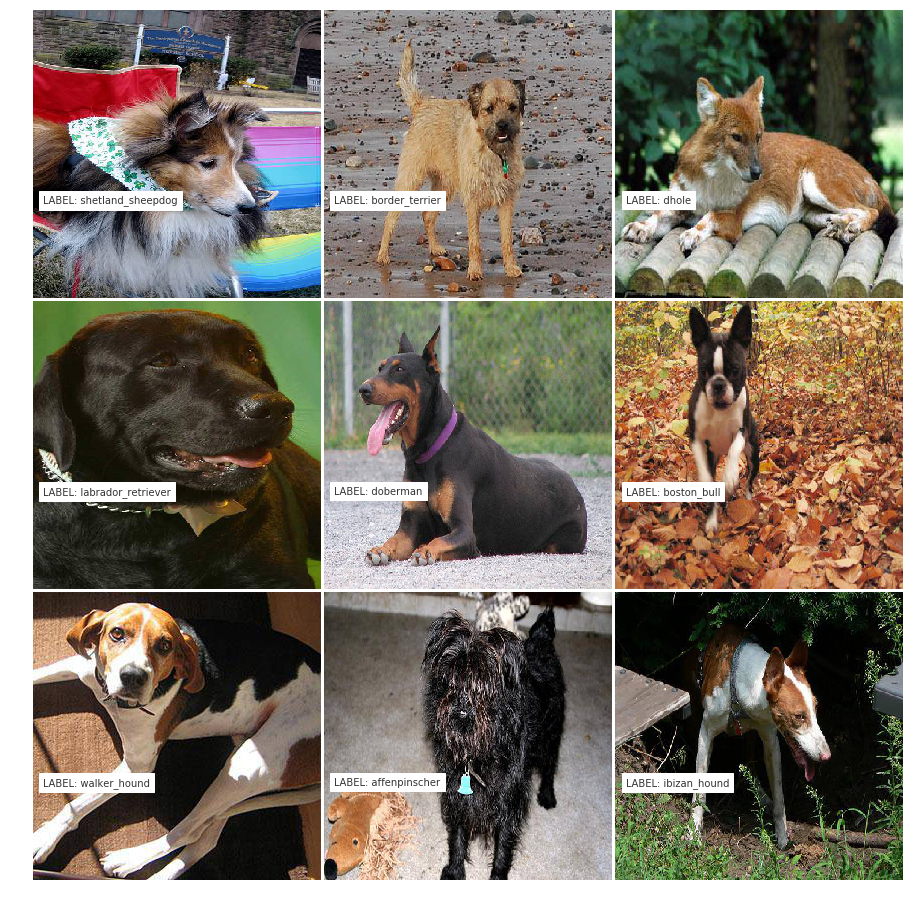

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_img(img, label, ax):
    ax.imshow(img / 255.)
    ax.text(10, 200, 'LABEL: {}'.format(label), color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')


fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.05)
for i, idx in enumerate(np.random.choice(list(range(len(labels))), size=9)):
    ax = grid[i]
    show_img(read_img(labels['id'][idx], "train", (299, 299)), label=labels['breed'][idx], ax=ax)
plt.show()

In [9]:
# options
INPUT_SIZE = 299
BATCH_SIZE = min(1,len(labels))

x_train = np.zeros((train_idx.sum(), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
x_valid = np.zeros((valid_idx.sum(), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
train_i = 0
valid_i = 0
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    if train_idx[i]:
        x_train[train_i] = x
        train_i += 1
    elif valid_idx[i]:
        x_valid[valid_i] = x
        valid_i += 1
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

100it [00:00, 133.80it/s]

Train Images shape: (87, 299, 299, 3) size: 23,333,661


In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator()

In [11]:
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input

In [12]:
# create the base pre-trained model
base_model = xception.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have NUM_CLASSES classes
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint

# checkpoints
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
STAMP = "{}_dog_breed_model".format(datetime.date.today().strftime("%Y-%m-%d"))

bst_model_path = "models/{}.h5".format(STAMP)
model_checkpoint = ModelCheckpoint(bst_model_path,
                                   save_best_only=True,
                                   save_weights_only=True)

# Authors suggest setting step_size = (2-8) x (training iterations in epoch)
step_size = 2000
clr = CyclicLR(base_lr=0.0001,
               max_lr=0.001,
               step_size=step_size,
               mode='exp_range',
               gamma=0.99994)

In [14]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [ ]:
# train the model on the new data for a few epochs
hist = model.fit_generator(train_datagen.flow(x_train, ytr, batch_size=BATCH_SIZE),
                           steps_per_epoch=train_idx.sum() // BATCH_SIZE,
                           epochs=50, callbacks=[early_stopping, model_checkpoint, clr],
                           validation_data=test_datagen.flow(x_valid, yv, batch_size=BATCH_SIZE),
                           validation_steps=valid_idx.sum() // BATCH_SIZE)